<img align="center" src="../extra/logos/logos.png" width='1200px'>

In [1]:
import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from odc.ui import DcViewer

from datacube.utils import masking
from datacube.utils.rio import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True)

In [2]:
dc = datacube.Datacube(app='SAMSARA') # https://opendatacube.readthedocs.io/en/latest/api/core-classes/datacube.html

In [3]:
query = {
     "product": "landsat8_c2l2_sr",
     # "product": "s2_l2a",
     "x": (-73.5, -72.5),
     "y": (-40, -39),
     "time": ("2022-02-01", "2022-04-30"),
     "output_crs": "EPSG:32719",
     "resolution": (-30, 30),
     "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
     "group_by": "solar_day"
}

In [4]:
ds = dc.load(**query)

# 1. Depurar información: enmascarar valores no válidos

In [5]:
from datacube.utils import masking

In [6]:
masking.describe_variable_flags(ds.qa_pixel)

,bits,values,description
snow,5,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
clear,6,"{'0': 'not_clear', '1': 'clear'}",NaN
cloud,3,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
water,7,"{'0': 'land_or_cloud', '1': 'water'}",NaN
cirrus,2,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
nodata,0,"{'0': False, '1': True}",NaN
qa_pixel,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{'1': 'Fill', '2': 'Dilated Cloud', '4': 'Cirr...",Level 2 pixel quality
cloud_shadow,4,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
dilated_cloud,1,"{'0': 'not_dilated', '1': 'dilated'}",NaN
cloud_confidence,"[8, 9]","{'0': 'none', '1': 'low', '2': 'medium', '3': ...",NaN


In [7]:
quality_band = 'qa_pixel'
cloud_free_mask = (
    masking.make_mask(ds[quality_band], snow='high_confidence') | 
    masking.make_mask(ds[quality_band], cloud="high_confidence") |
    masking.make_mask(ds[quality_band], cirrus="high_confidence") |
    masking.make_mask(ds[quality_band], cloud_shadow="high_confidence") |
    masking.make_mask(ds[quality_band], nodata=True)
)

In [8]:
dsf = xr.where(cloud_free_mask, np.nan, ds)

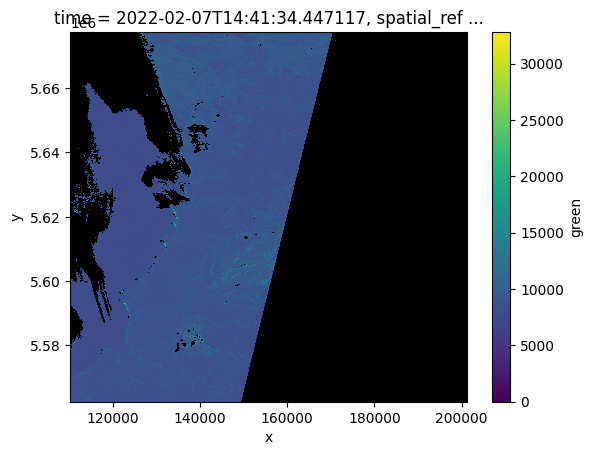

In [9]:
fig, ax = plt.subplots(1, 1)
dsf.green.isel(time=0).plot()
ax.set_facecolor("black")

# 2. Índices espectrales

[Documentación oficial](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) del producto de Landsat

In [10]:
dsf.update(dsf * 0.0000275 + -0.2)

<xarray.Dataset>
Dimensions:      (time: 10, y: 3830, x: 3032)
Coordinates:
  * time         (time) datetime64[ns] 2022-02-07T14:41:34.447117 ... 2022-04...
  * y            (y) float64 5.677e+06 5.677e+06 ... 5.563e+06 5.563e+06
  * x            (x) float64 1.103e+05 1.103e+05 ... 2.012e+05 2.012e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    qa_pixel     (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    qa_aerosol   (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    qa_radsat    (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

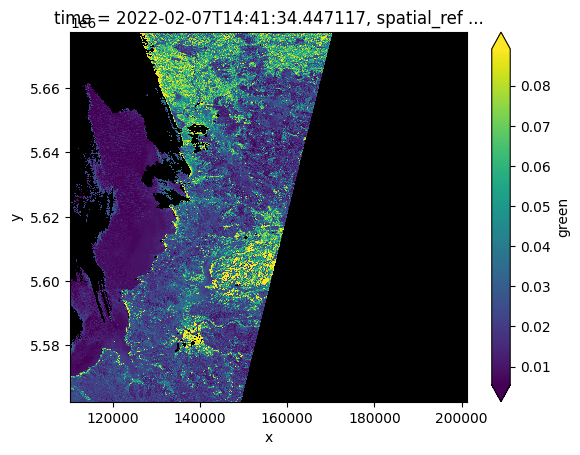

In [11]:
fig, ax = plt.subplots(1, 1)
dsf.green.isel(time=0).plot(robust=True)
ax.set_facecolor("black")

In [12]:
ndvi = (dsf['nir08'] - dsf['red']) / (dsf['nir08'] + dsf['red'])
ndvi

<xarray.DataArray (time: 10, y: 3830, x: 3032)>
dask.array<truediv, shape=(10, 3830, 3032), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-02-07T14:41:34.447117 ... 2022-04...
  * y            (y) float64 5.677e+06 5.677e+06 ... 5.563e+06 5.563e+06
  * x            (x) float64 1.103e+05 1.103e+05 ... 2.012e+05 2.012e+05
    spatial_ref  int32 32719

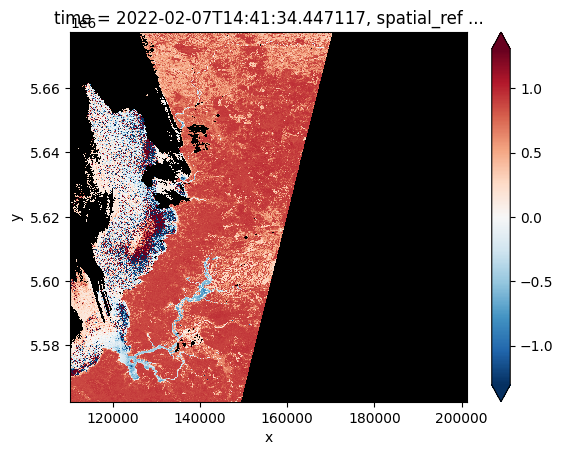

In [13]:
fig, ax = plt.subplots(1, 1)
ndvi.isel(time=0).plot(robust=True)
ax.set_facecolor("black")

In [14]:
evi = 2.5 * ((dsf['nir08'] - dsf['red']) / (dsf['nir08'] + 6 * dsf['red'] - 7.5 * dsf['blue'] + 1) )

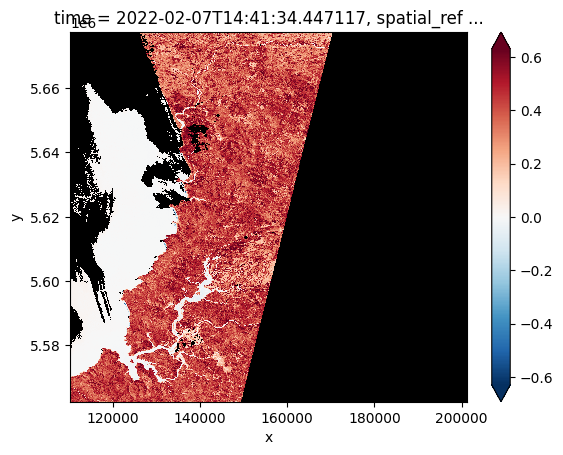

In [15]:
fig, ax = plt.subplots(1, 1)
evi.isel(time=0).plot(robust=True)
ax.set_facecolor("black")

# 3. Compuestos

In [16]:
ndvi_mean = ndvi.mean(dim="time")
ndvi_mean

<xarray.DataArray (y: 3830, x: 3032)>
dask.array<mean_agg-aggregate, shape=(3830, 3032), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.677e+06 5.677e+06 ... 5.563e+06 5.563e+06
  * x            (x) float64 1.103e+05 1.103e+05 ... 2.012e+05 2.012e+05
    spatial_ref  int32 32719

/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


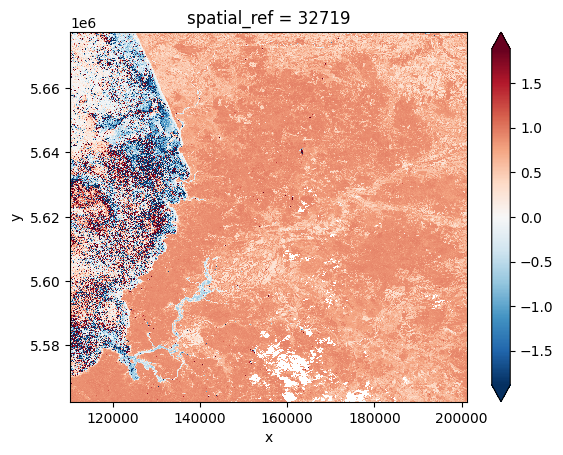

In [17]:
ndvi_mean.plot(robust=True)

In [18]:
ndvi.median(dim="time")

<xarray.DataArray (y: 3830, x: 3032)>
dask.array<nanmedian, shape=(3830, 3032), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.677e+06 5.677e+06 ... 5.563e+06 5.563e+06
  * x            (x) float64 1.103e+05 1.103e+05 ... 2.012e+05 2.012e+05
    spatial_ref  int32 32719

In [19]:
ndvi.min(dim="time")

<xarray.DataArray (y: 3830, x: 3032)>
dask.array<_nanmin_skip-aggregate, shape=(3830, 3032), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.677e+06 5.677e+06 ... 5.563e+06 5.563e+06
  * x            (x) float64 1.103e+05 1.103e+05 ... 2.012e+05 2.012e+05
    spatial_ref  int32 32719

In [20]:
ndvi.max(dim="time")

<xarray.DataArray (y: 3830, x: 3032)>
dask.array<_nanmax_skip-aggregate, shape=(3830, 3032), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.677e+06 5.677e+06 ... 5.563e+06 5.563e+06
  * x            (x) float64 1.103e+05 1.103e+05 ... 2.012e+05 2.012e+05
    spatial_ref  int32 32719

In [21]:
ndvi.groupby('time.month').max()

<xarray.DataArray (month: 3, y: 3830, x: 3032)>
dask.array<stack, shape=(3, 3830, 3032), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.677e+06 5.677e+06 ... 5.563e+06 5.563e+06
  * x            (x) float64 1.103e+05 1.103e+05 ... 2.012e+05 2.012e+05
    spatial_ref  int32 32719
  * month        (month) int64 2 3 4

# 4. Exportar información

In [22]:
from datacube.utils.cog import write_cog

run = True
if run:
    for i in range(len(ndvi.time)):
        date = ndvi.time[0].dt.strftime("%Y%m%d")
        out = ndvi.isel(time=i)
        write_cog(geo_im=out, fname=f'{date}_ndvi.tif', overwrite=True).compute()

ValueError: Need geo-registered array on input